In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns  # for plotting confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Set image size and batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [4]:
# Load dataset
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potato_disease_dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3909 files belonging to 4 classes.


In [5]:
# Get class names
class_names = df.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'unknown']

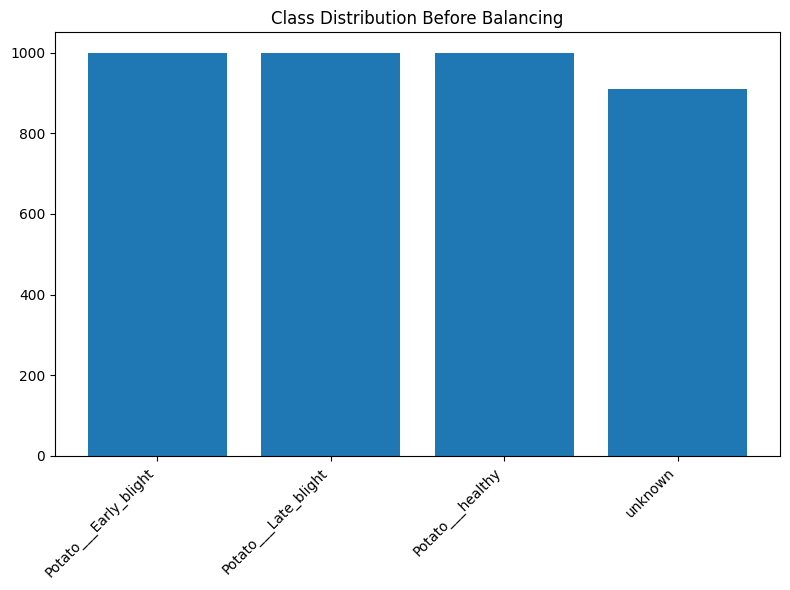

In [6]:
import os
# Visualizing the class distribution (before balancing)
directory = "/content/drive/MyDrive/potato_disease_dataset"
class_count = {class_name: len(os.listdir(os.path.join(directory, class_name))) for class_name in class_names}
plt.figure(figsize=(8, 6))  # Adjust the figure size
plt.bar(class_count.keys(), class_count.values())
plt.title("Class Distribution Before Balancing")
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [7]:
# Check if dataset is imbalanced
print(f"Class Counts: {class_count}")

Class Counts: {'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 1000, 'unknown': 909}


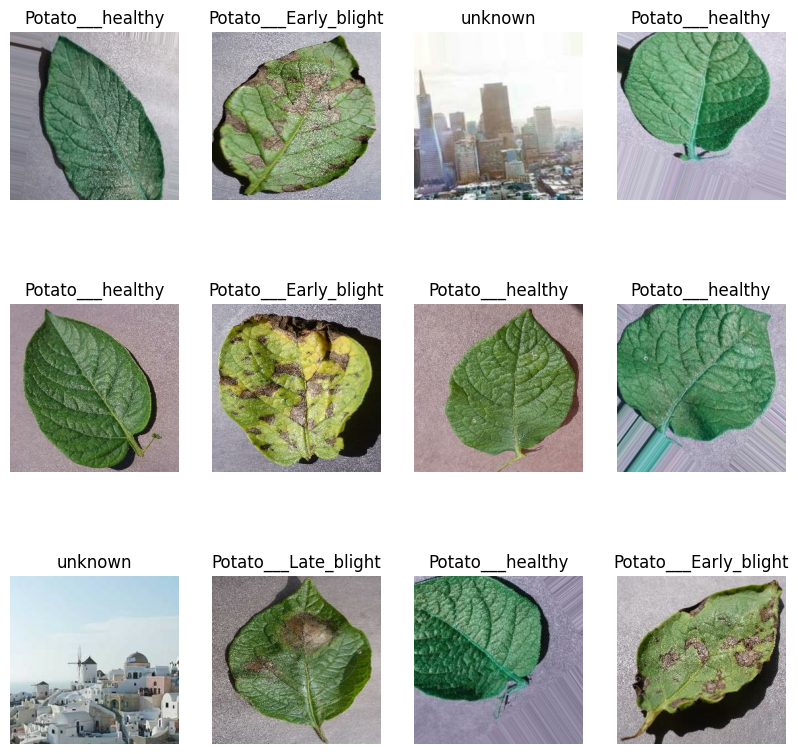

In [8]:
# Plot sample images with labels
plt.figure(figsize=(10, 10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
# Split the dataset into training, validation, and test sets
def split_datasets(pc, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size, seed=10)

    pc_size = len(pc)
    train_size = int(train_split * pc_size)
    val_size = int(val_split * pc_size)

    train_pc = pc.take(train_size)
    val_pc = pc.skip(train_size).take(val_size)
    test_pc = pc.skip(train_size).skip(val_size)

    return train_pc, val_pc, test_pc

train_data, val_data, test_data = split_datasets(df)

In [10]:
# Cache, shuffle, and prefetch data
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# Image preprocessing: rescaling and resizing
rescale_n_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [12]:
# Data augmentation: flipping and rotating images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.5)
])

In [13]:
# Assuming you already have this from your dataset
num_classes = 4  # Set this to the number of classes in your dataset

# Build the CNN model with Input layer
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Note: Do not include BATCH_SIZE here

model = models.Sequential([
    layers.Input(shape=input_shape),  # Specify input shape here
    rescale_n_resize,
    data_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Set to 4 units for 4 classes
])

# Display the model summary
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,436 (1.29 MB)

 Trainable params: 338,436 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Use categorical crossentropy for multi-class
              metrics=['accuracy'])




In [15]:
# Fitting the model
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 455s 175ms/step - accuracy: 0.3697 - loss: 1.2622 - val_accuracy: 0.7507 - val_loss: 0.6470
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.7476 - loss: 0.6367 - val_accuracy: 0.8828 - val_loss: 0.3332
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.8450 - loss: 0.3874 - val_accuracy: 0.9062 - val_loss: 0.2590
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.9039 - loss: 0.2441 - val_accuracy: 0.8594 - val_loss: 0.3458
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.9163 - loss: 0.2389 - val_accuracy: 0.9167 - val_loss: 0.2243
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.9299 - loss: 0.1972 - val_accuracy: 0.9245 - val_loss: 0.2010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.8400 - loss: 0.4736 - val_accuracy: 0.9036 - val_loss: 0.3273
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9260 - loss: 0.1870 - val_acc

In [16]:
# Evaluating the model
scores = model.evaluate(test_data)
print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9824 - loss: 0.0364
Test loss: 0.041736844927072525, Test accuracy: 0.9831730723381042


In [17]:
# Get history keys
history.params, history.history.keys()

({'verbose': 1, 'epochs': 20, 'steps': 98},
 dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss']))

In [18]:
# Assign training and validation results
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

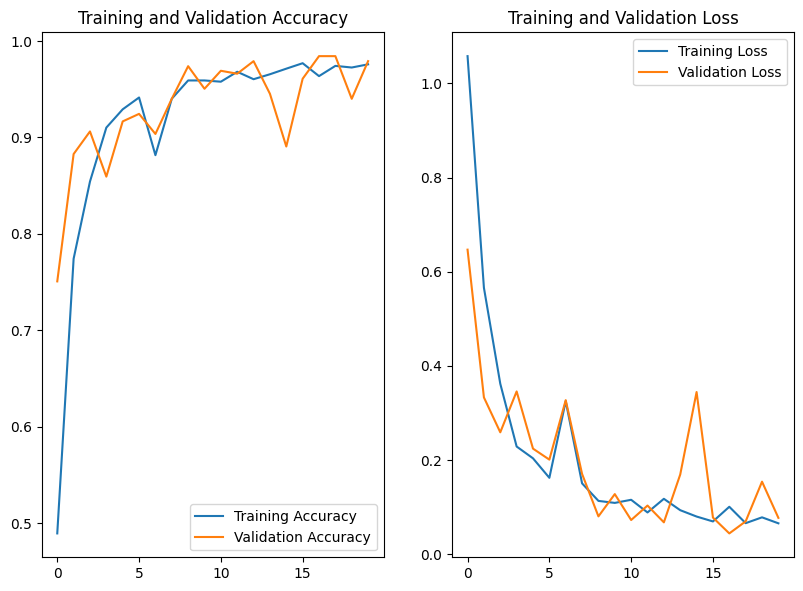

In [19]:
# Plot accuracy and loss graphs
plt.figure(figsize=(15, 15))

# Accuracy plot
plt.subplot(2, 3, 1)
plt.plot(range(EPOCHS), train_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 3, 2)
plt.plot(range(EPOCHS), train_loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()  # Add this line to display the plot


In [20]:
# Confusion Matrix and Classification Report
y_true = []
y_pred = []

In [21]:
# Iterate over the test dataset to get true and predicted labels
for batch_image, batch_label in test_pc:
    batch_prediction = model.predict(batch_image)
    y_true.extend(batch_label.numpy())
    y_pred.extend(np.argmax(batch_prediction, axis=-1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [22]:
# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

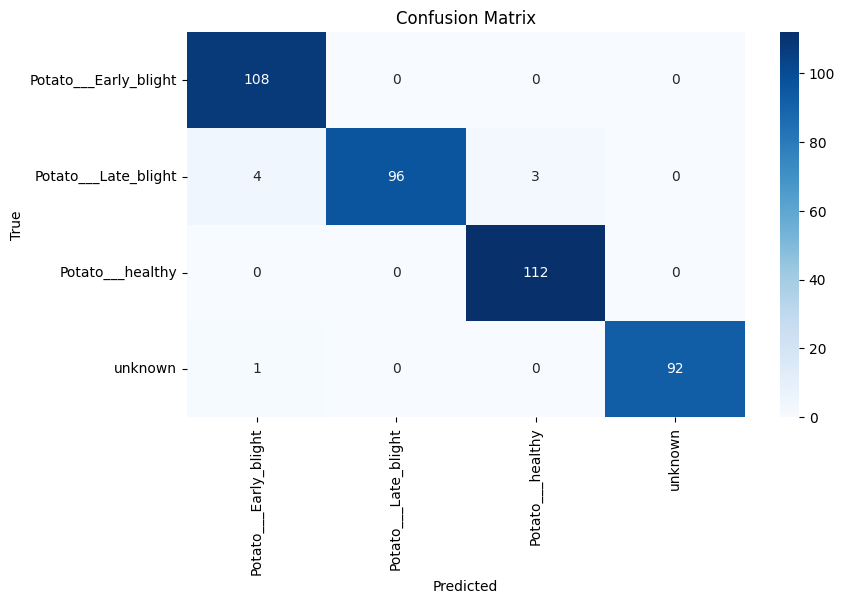

In [24]:
# Plot confusion matrix
plt.figure(figsize=(9, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.96      1.00      0.98       108
 Potato___Late_blight       1.00      0.93      0.96       103
     Potato___healthy       0.97      1.00      0.99       112
              unknown       1.00      0.99      0.99        93

             accuracy                           0.98       416
            macro avg       0.98      0.98      0.98       416
         weighted avg       0.98      0.98      0.98       416



In [38]:
# Save the model in Keras format
model.save('potato_with_balance_dataset.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


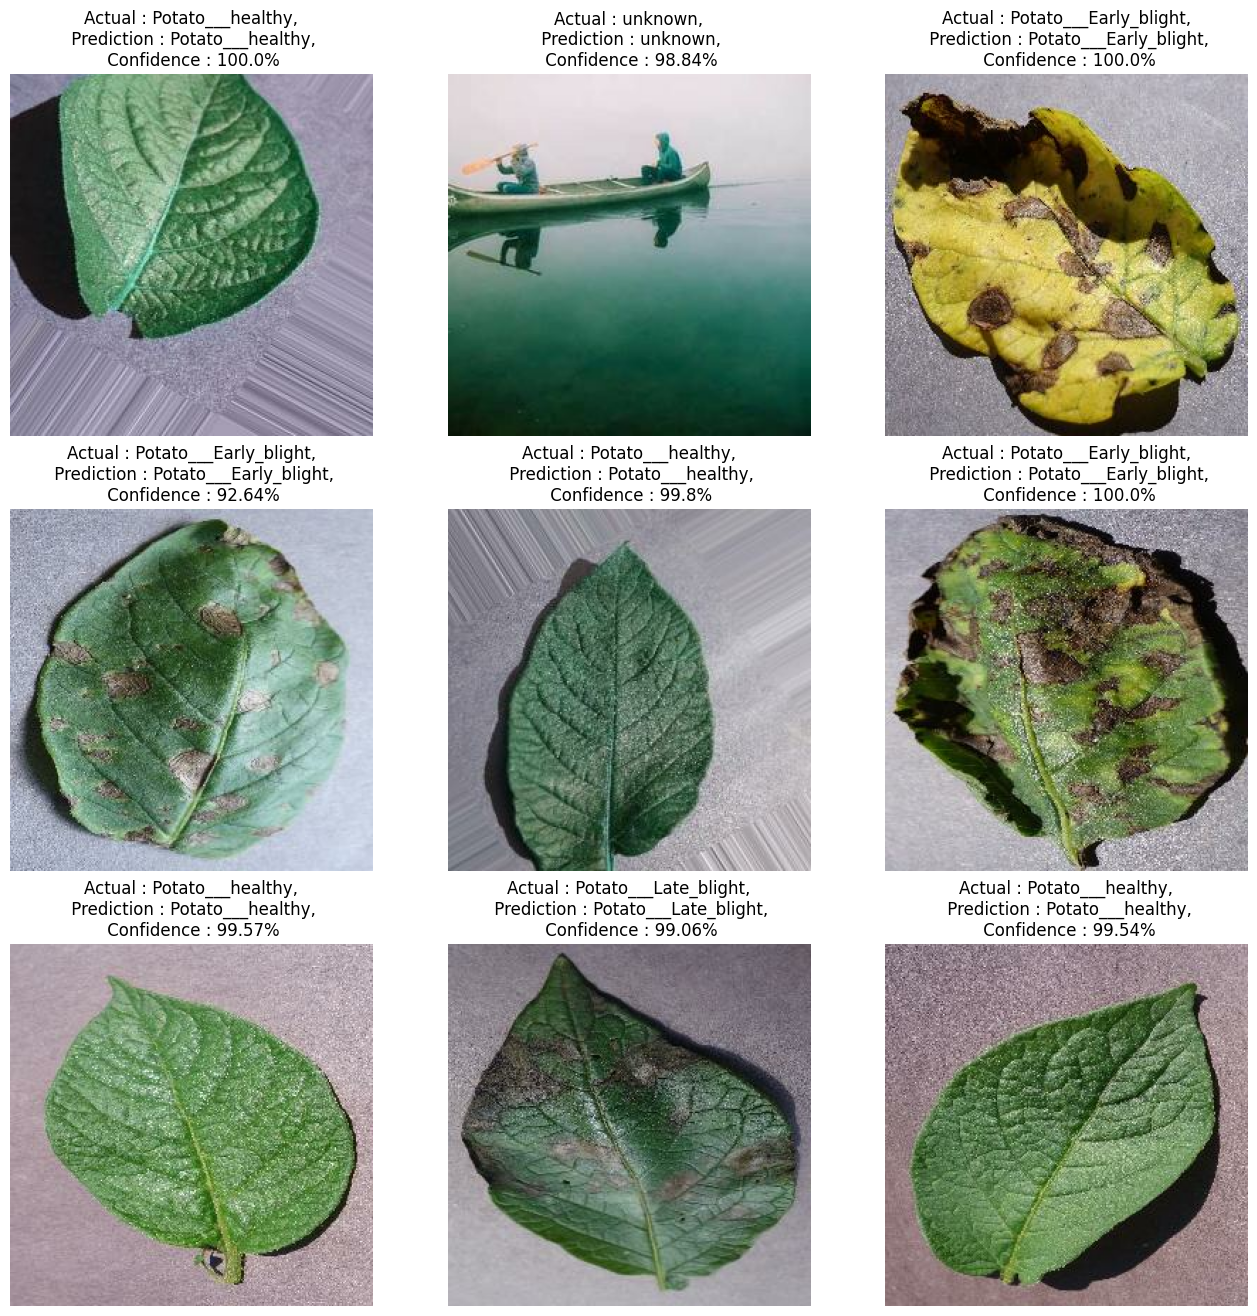

In [46]:
# plotting batch of test images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_pc.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]

        plt.imshow(image)

        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')

        plt.axis('off')